In [15]:
import yaml
import pandas as pd

In [19]:
with open('../../configs/rumc_new.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [20]:
config

{'dataset': {'name': 'rumc',
  'target': 'DIAGNOSIS',
  'evaluation': {'n_folds': 5, 'metrics': ['roc_auc']}},
 'pipeline': "from sklearn.impute import SimpleImputer\nfrom lightgbm.sklearn import LGBMRegressor\nfrom sklearn.pipeline import make_pipeline\npipeline = make_pipeline(\n  SimpleImputer(strategy='mean'),\n  LGBMRegressor(n_jobs=-1, boosting_type='dart')\n)"}

In [23]:
local = {}
exec(config['pipeline'], globals(), local)
local['pipeline']

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('lgbmregressor', LGBMRegressor(boosting_type='dart'))])

In [4]:
from marshmallow import fields, ValidationError
import importlib
from sklearn.pipeline import Pipeline
class PipelineConfig(fields.Field):
    def _serialize(self, value, attr, obj, **kwargs):
        return 0
    
    def _generate_class(self, cls_desc):
        print(cls_desc)
        module_name = '.'.join(cls_desc['cls'].split('.')[:-1])
        cls_name = cls_desc['cls'].split('.')[-1]
        clz = getattr(importlib.import_module(module_name), cls_name)
        instance = clz(**cls_desc['params'])
        return instance
        
    
    def _deserialize(self, value, attr, data, **kwargs):
        steps = []
        for step_desc in value:
            step_name = list(step_desc.keys())[0]
            step_value = list(step_desc.values())[0]
            steps.append((step_name, self._generate_class(step_value)))
        return Pipeline(steps)

In [8]:
# from __future__ import annotations
from marshmallow import Schema, fields, validate
from dataclasses import field
from marshmallow_dataclass import dataclass, NewType
from typing import Any, Dict, Optional, List, Union
from enum import Enum
import sklearn
import sklearn.metrics

class DatasetTarget(Enum):
    PCR = 'pcr'
    CORADS = 'corads'
    DIAGNOSIS = 'diagnosis'

    @property
    def is_classification(self):
        if self == DatasetTarget.PCR or self == DatasetTarget.DIAGNOSIS:
            return True
        return False

class FeatureSelectionType(Enum):
    SFM = 'sfm'
    RFE = 'rfe'


class ImputationType(Enum):
    MEAN = 'mean'
    MEDIAN = 'median'
    CONSTANT = 'constant'

    def generate_imputer(self):
        from sklearn.impute import SimpleImputer
        if self == ImputationType.MEAN:
            return SimpleImputer(strategy='mean')
        elif self == ImputationType.MEDIAN:
            return SimpleImputer(strategy='median')
        elif self == ImputationType.CONSTANT:
            return SimpleImputer(strategy='constant', fill_value='missing')
        raise ValueError(f'Invalid config: {self.value}')


Metric = NewType('Metric', str, fields.String, required=True,
                 validate=validate.OneOf(['thresh_accuracy', 'corads_roc_auc'] + list(sklearn.metrics.SCORERS.keys())))


@dataclass
class EvaluationConfig:
    n_folds: int = field(metadata={'validate': validate.Range(min=2)})
    metrics: List[Metric]


@dataclass
class DatasetConfig(Schema):
    name: str
    target: DatasetTarget
    evaluation: EvaluationConfig


@dataclass
class ImputationConfig(Schema):
    categorical: ImputationType
    numeric: ImputationType


@dataclass
class FeatureSelectionConfig(Schema):
    fs_type: FeatureSelectionType
    num_features: Optional[int]
    use_clinical_features: bool = field(default=True)
    use_visual_features: bool = field(default=True)

    def generate_selector(self):
        from lightgbm import LGBMClassifier
        if self.fs_type == FeatureSelectionType.RFE:
            from sklearn.feature_selection import RFE
            return RFE(LGBMClassifier(n_jobs=-1), n_features_to_select=self.num_features)
        elif self.fs_type == FeatureSelectionType.SFM:
            from sklearn.feature_selection import SelectFromModel
            return SelectFromModel(LGBMClassifier(n_jobs=-1), max_features=self.num_features)
        raise ValueError(f'Invalid config: {self.fs_type}')


@dataclass
class PreprocessingConfig(Schema):
    imputation: ImputationConfig
    feature_selection: FeatureSelectionConfig

@dataclass
class ClassDescription:
    cls: str
    params: Dict[str, Union[str, bool, int, float, 'ClassDescription']]

@dataclass
class Config:
    dataset: DatasetConfig
#     preprocessing: PreprocessingConfig
#     model_parameters: Dict[str, Any]
    pipeline: List[Dict[str, ClassDescription]]
#     pipeline: List[Dict[str, Any]] = field(metadata = {
#         'marshmallow_field': PipelineConfig()
#     })


ConfigSchema = Config.Schema()

In [9]:
config_parsed = Config.Schema().load(config)

In [10]:
config_parsed

Config(dataset=DatasetConfig(name='rumc', target=<DatasetTarget.DIAGNOSIS: 'diagnosis'>, evaluation=EvaluationConfig(n_folds=5, metrics=['roc_auc'])), pipeline=[{'impute': ClassDescription(cls='sklearn.impute.SimpleImputer', params={'strategy': 'mean'})}, {'clf': ClassDescription(cls='lightgbm.sklearn.LGBMClassifier', params={'n_estimators': 100, 'boosting_type': 'dart'})}])

In [11]:
!pip install mpld3

You should consider upgrading via the 'c:\users\roel\.virtualenvs\diagcovid-ckc2berq\scripts\python.exe -m pip install --upgrade pip' command.



  Created wheel for mpld3: filename=mpld3-0.5.2-py3-none-any.whl size=200617 sha256=5f87f3220015896ba75d21a6913bcd4a571eeeae0ccf9a1b03a65df8641d2790
  Stored in directory: c:\users\roel\appdata\local\pip\cache\wheels\11\af\f9\b3fc6166b9a794dcde7e64b183d48d495aa0f5e469d73ef385
Successfully built mpld3



Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [30/Apr/2021 14:36:19] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Apr/2021 14:36:19] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [30/Apr/2021 14:36:19] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


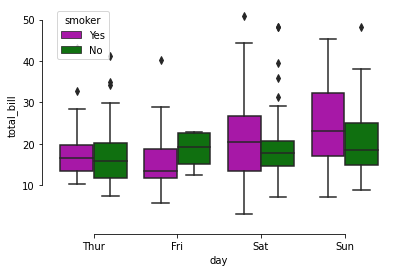

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
# sns.set_theme(style="darkgrid")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="day", y="total_bill",
            hue="smoker", palette=["m", "g"],
            data=tips)
sns.despine(offset=10, trim=True)
mpld3.show()

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.impute import SimpleImputer
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
import os
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, get_scorer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder
import coolname
import random

from typing import Tuple

def generate_pipeline(X: pd.DataFrame, config: Config):
    categorical_columns = list(X.select_dtypes(include=['category']).columns)
    numerical_columns = list(X.select_dtypes(exclude=['category']).columns)

    cateogrical_preprocessor = make_pipeline(
        config.preprocessing.imputation.categorical.generate_imputer(),
        OrdinalEncoder(categories=[list(X[col].cat.categories) for col in categorical_columns])
    )
    numerical_preprocessor = config.preprocessing.imputation.numeric.generate_imputer()

    imputation = ColumnTransformer([
        ('categorical', cateogrical_preprocessor, categorical_columns),
        ('numerical', numerical_preprocessor, numerical_columns)
    ])

    clf = Pipeline([
        ('imputation', imputation),
        ('feature_selection', config.preprocessing.feature_selection.generate_selector()),
        ('classifier', LGBMClassifier(n_jobs=-1,
                                      **config.model_parameters) if config.dataset.target.is_classification else LGBMRegressor(
            n_jobs=-1, **config.model_parameters))
    ])

    return clf


def load_data(config: Config) -> Tuple[pd.DataFrame, pd.Series]:
    if config.dataset.name == 'ictcf':
        return load_ictcf()
    elif config.dataset.name == 'rumc':
        X, y = load_rumc(config.dataset.target)
        not_nan = (y != 'nan') & ~y.isna()
        return X[not_nan], y[not_nan]


def thresh_accuracy(y, y_pred):
    y_thresh = y >= 2
    y_pred_thresh = y_pred >= 2
    return accuracy_score(y_thresh, y_pred_thresh)


def corads_roc_auc(y, y_pred):
    y_thresh = np.round(y / 5)
    y_pred_thresh = y_pred / 5
    return roc_auc_score(y_thresh, y_pred_thresh)

@dataclass
class Features:
    categorical_features: List[str]
    numeric_features: List[str]
    output_feature: str
    visual_features: List[str] = field(default_factory=lambda: [])

    @property
    def input_features(self) -> List[str]:
        return self.categorical_features + self.numeric_features + self.visual_features


def load_rumc(target: DatasetTarget) -> Tuple[pd.DataFrame, pd.Series]:
    df = pd.read_pickle('../data/processed/rumc.pkl')
    features = get_rumc_features(df, target)
    return df[features.input_features], df[features.output_feature]

def get_rumc_features(df: pd.DataFrame, target: DatasetTarget) -> Features:
    non_visual_features = list(df.columns[~df.columns.isin(['pcr', 'corads', 'diagnosis', 'part']) & ~df.columns.str.startswith('vis_')])
    visual_features = list(df.columns[df.columns.str.startswith('vis_')])
    output_feature = {
        DatasetTarget.PCR: 'pcr',
        DatasetTarget.CORADS: 'corads',
        DatasetTarget.DIAGNOSIS: 'diagnosis'
    }[target]
    numerical_features = list(df[non_visual_features].select_dtypes(exclude='category').columns)
    categorical_features = list(df[non_visual_features].select_dtypes(include='category').columns)

    return Features(categorical_features, numerical_features, output_feature, visual_features)



def evaluate(config: Config):
    print('Loading data...')
    X, y = load_data(config)

    print('Generating pipeline...')
    clf = generate_pipeline(X, config)

    print('Evaluating pipeline on data...')
    categorical_columns = list(X.select_dtypes(include=['category']).columns)
    custom_metrics = {
        'thresh_accuracy': make_scorer(thresh_accuracy),
        'corads_roc_auc': make_scorer(corads_roc_auc)
    }
    metrics = {metric: (custom_metrics[metric] if metric in custom_metrics else get_scorer(metric)) for metric in
               config.dataset.evaluation.metrics}
    results = cross_validate(clf, X, y, scoring=metrics,
                             cv=config.dataset.evaluation.n_folds)

    model_name = coolname.generate_slug(random.choice([2, 2, 2, 2, 2, 2, 3]))

    print(f'Saving results (model name: "{model_name}")...')
    df_results = pd.DataFrame(results)
    df_results.columns = 'value_' + df_results.columns
    df_results['fold'] = df_results.index
    df_results = pd.wide_to_long(df_results, stubnames=['value'], sep='_', suffix='.+', i='fold', j='metric')
    df_results = df_results.reset_index()

    df_results['model'] = model_name
    df_results['timestamp'] = pd.Timestamp.now()

    config_dict = ConfigSchema.dump(config)
    df_config = pd.json_normalize(config_dict)
    df_config.columns = 'config.' + df_config.columns
    df_full = pd.concat([df_results, df_config.loc[[0] * len(df_results)].reset_index()], axis=1)
    return df_full
#     df_full.to_pickle(os.path.join(DATA_RESULTS_PATH, f'{model_name}.pkl'))


In [44]:
evaluate(config_parsed)

Loading data...
Generating pipeline...
Evaluating pipeline on data...
Saving results (model name: "daring-dolphin")...


,fold,metric,value,model,timestamp,index,config.preprocessing.imputation.numeric,config.preprocessing.imputation.categorical,config.preprocessing.feature_selection.use_clinical_features,config.preprocessing.feature_selection.use_visual_features,config.preprocessing.feature_selection.num_features,config.preprocessing.feature_selection.fs_type,config.model_parameters.boosting_type,config.model_parameters.n_estimators,config.model_parameters.learning_rate,config.dataset.evaluation.n_folds,config.dataset.evaluation.metrics,config.dataset.target,config.dataset.name
0,0,fit_time,0.376000,daring-dolphin,2021-04-05 21:54:02.802258,0,MEAN,CONSTANT,True,True,1100,SFM,dart,40,0.01,5,[roc_auc],DIAGNOSIS,rumc
1,1,fit_time,0.405002,daring-dolphin,2021-04-05 21:54:02.802258,0,MEAN,CONSTANT,True,True,1100,SFM,dart,40,0.01,5,[roc_auc],DIAGNOSIS,rumc
2,2,fit_time,0.398999,daring-dolphin,2021-04-05 21:54:02.802258,0,MEAN,CONSTANT,True,True,1100,SFM,dart,40,0.01,5,[roc_auc],DIAGNOSIS,rumc
3,3,fit_time,0.397002,daring-dolphin,2021-04-05 21:54:02.802258,0,MEAN,CONSTANT,True,True,1100,SFM,dart,40,0.01,5,[roc_auc],DIAGNOSIS,rumc
4,4,fit_time,0.405003,daring-dolphin,2021-04-05 21:54:02.802258,0,MEAN,CONSTANT,True,True,1100,SFM,dart,40,0.01,5,[roc_auc],DIAGNOSIS,rumc
5,0,score_time,0.142002,daring-dolphin,2021-04-05 21:54:02.802258,0,MEAN,CONSTANT,True,True,1100,SFM,dart,40,0.01,5,[roc_auc],DIAGNOSIS,rumc
6,1,score_time,0.139000,daring-dolphin,2021-04-05 21:54:02.802258,0,MEAN,CONSTANT,True,True,1100,SFM,dart,40,0.01,5,[roc_auc],DIAGNOSIS,rumc
7,2,score_time,0.135001,daring-dolphin,2021-04-05 21:54:02.802258,0,MEAN,CONSTANT,True,True,1100,SFM,dart,40,0.01,5,[roc_auc],DIAGNOSIS,rumc
8,3,score_time,0.141000,daring-dolphin,2021-04-05 21:54:02.802258,0,MEAN,CONSTANT,True,True,1100,SFM,dart,40,0.01,5,[roc_auc],DIAGNOSIS,rumc
9,4,score_time,0.138000,daring-dolphin,2021-04-05 21:54:02.802258,0,MEAN,CONSTANT,True,True,1100,SFM,dart,40,0.01,5,[roc_auc],DIAGNOSIS,rumc


In [30]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [180]:
from sklearn.model_selection import cross_validate
results = cross_validate(clf, X, y, scoring=config_parsed.dataset.evaluation.metrics, cv=config_parsed.dataset.evaluation.n_folds)

In [194]:
df_results = pd.DataFrame(results)
df_results.columns = 'value_' + df_results.columns
df_results['fold'] = df_results.index
df_results = pd.wide_to_long(df_results, stubnames=['value'], sep='_', suffix='.+', i='fold', j='metric')
df_results = df_results.reset_index()

In [264]:
import coolname
import random
model_name = coolname.generate_slug(random.choice([2, 2, 2, 2, 2, 2, 3]))

In [265]:
df_results['model'] = model_name
df_results['timestamp'] = pd.Timestamp.now()
df_results

,fold,metric,value,model,timestamp
0,0,fit_time,1.108999,quantum-crayfish,2021-04-02 13:59:09.187006
1,1,fit_time,1.058001,quantum-crayfish,2021-04-02 13:59:09.187006
2,2,fit_time,1.035001,quantum-crayfish,2021-04-02 13:59:09.187006
3,3,fit_time,1.151002,quantum-crayfish,2021-04-02 13:59:09.187006
4,4,fit_time,0.992002,quantum-crayfish,2021-04-02 13:59:09.187006
5,0,score_time,0.007998,quantum-crayfish,2021-04-02 13:59:09.187006
6,1,score_time,0.008000,quantum-crayfish,2021-04-02 13:59:09.187006
7,2,score_time,0.009000,quantum-crayfish,2021-04-02 13:59:09.187006
8,3,score_time,0.006998,quantum-crayfish,2021-04-02 13:59:09.187006
9,4,score_time,0.007998,quantum-crayfish,2021-04-02 13:59:09.187006


In [282]:
df_config = pd.json_normalize(config)
df_config.columns = 'config.' + df_config.columns
df_full = pd.concat([df_results, df_config.loc[[0]*len(df_results)].reset_index()], axis=1)
df_full

,fold,metric,value,model,timestamp,index,config.dataset.name,config.dataset.target,config.dataset.evaluation.n_folds,config.dataset.evaluation.metrics,config.preprocessing.imputation.categorical,config.preprocessing.imputation.numeric,config.preprocessing.feature_selection.fs_type,config.model_parameters.boosting_type,config.model_parameters.n_estimators,config.model_parameters.learning_rate
0,0,fit_time,1.108999,quantum-crayfish,2021-04-02 13:59:09.187006,0,ictcf,PCR,5,"[roc_auc, accuracy, f1_weighted]",CONSTANT,MEAN,RFE,dart,40,0.01
1,1,fit_time,1.058001,quantum-crayfish,2021-04-02 13:59:09.187006,0,ictcf,PCR,5,"[roc_auc, accuracy, f1_weighted]",CONSTANT,MEAN,RFE,dart,40,0.01
2,2,fit_time,1.035001,quantum-crayfish,2021-04-02 13:59:09.187006,0,ictcf,PCR,5,"[roc_auc, accuracy, f1_weighted]",CONSTANT,MEAN,RFE,dart,40,0.01
3,3,fit_time,1.151002,quantum-crayfish,2021-04-02 13:59:09.187006,0,ictcf,PCR,5,"[roc_auc, accuracy, f1_weighted]",CONSTANT,MEAN,RFE,dart,40,0.01
4,4,fit_time,0.992002,quantum-crayfish,2021-04-02 13:59:09.187006,0,ictcf,PCR,5,"[roc_auc, accuracy, f1_weighted]",CONSTANT,MEAN,RFE,dart,40,0.01
5,0,score_time,0.007998,quantum-crayfish,2021-04-02 13:59:09.187006,0,ictcf,PCR,5,"[roc_auc, accuracy, f1_weighted]",CONSTANT,MEAN,RFE,dart,40,0.01
6,1,score_time,0.008000,quantum-crayfish,2021-04-02 13:59:09.187006,0,ictcf,PCR,5,"[roc_auc, accuracy, f1_weighted]",CONSTANT,MEAN,RFE,dart,40,0.01
7,2,score_time,0.009000,quantum-crayfish,2021-04-02 13:59:09.187006,0,ictcf,PCR,5,"[roc_auc, accuracy, f1_weighted]",CONSTANT,MEAN,RFE,dart,40,0.01
8,3,score_time,0.006998,quantum-crayfish,2021-04-02 13:59:09.187006,0,ictcf,PCR,5,"[roc_auc, accuracy, f1_weighted]",CONSTANT,MEAN,RFE,dart,40,0.01
9,4,score_time,0.007998,quantum-crayfish,2021-04-02 13:59:09.187006,0,ictcf,PCR,5,"[roc_auc, accuracy, f1_weighted]",CONSTANT,MEAN,RFE,dart,40,0.01


In [283]:
df_full.to_pickle(f'../data/results/{model_name}.pkl')

In [285]:
schema = Config.Schema()

In [286]:
schema.dump(config_parsed)

{'dataset': {'target': 'PCR',
  'name': 'ictcf',
  'evaluation': {'metrics': ['roc_auc', 'accuracy', 'f1_weighted'],
   'n_folds': 5}},
 'model_parameters': {'boosting_type': 'dart',
  'n_estimators': 40,
  'learning_rate': 0.01},
 'preprocessing': {'imputation': {'numeric': 'MEAN',
   'categorical': 'CONSTANT'},
  'feature_selection': {'fs_type': 'RFE', 'num_features': None}}}

In [232]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [138]:
!pip install coolname

In [130]:
!pip install "marshmallow-dataclass[enum,union]"

In [ ]:
class DatasetConfig(Schema):
    name = fields.String()
    target = fields.String(validate=validate.OneOf(['pcr', 'corads']))
    

class ImputationConfig(Schema):
    categorical = fields.String(required=True)
    numeric = fields.String(required=True)

class FeatureSelectionConfig(Schema):
    fs_type = fields.String(validate=validate.OneOf(['rfe', 'sfm']))
    num_features = fields.Int(strict=True, validate=validate.Range(min=1))
    
class PreprocessingConfig(Schema):
    imputation = fields.Nested(ImputationConfig)
    feature_selection = fields.Nested(FeatureSelectionConfig)

class Config(Schema):
    dataset = fields.Nested(DatasetConfig)
    preprocessing = fields.Nested(PreprocessingConfig)
    model_parameters = fields.Dict()

In [46]:
schema = Config()
config_dumped = schema.load(config)

TypeError: __init__() got an unexpected keyword argument 'dataset'

In [49]:
from marshmallow import Schema, fields, post_load


class UserSchema(Schema):
    name = fields.Str()
    email = fields.Email()
    created_at = fields.DateTime()

    @post_load
    def make_user(self, data, **kwargs):
        return User(**data)
    
user_data = {"name": "Ronnie", "email": "ronnie@stones.com"}
schema = UserSchema()
result = schema.load(user_data)
print(result)  # => <User(name='Ronnie')>

NameError: name 'User' is not defined

In [4]:
!pip install marshmallow